<a href="https://colab.research.google.com/github/melyneca/Calendar/blob/main/Ship_Classify_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Önce uygun kütüphaneler yüklenir


In [1]:
import torch
import torchvision.transforms as transforms
import pandas as pd
import os
from torch.utils.data import Dataset
from skimage import io
import torchvision
import numpy as np
import torch.nn as nn


Zip dosyası açılır ve extractall() ile dosyalar dışarı çıkarılır

In [2]:
from zipfile import ZipFile
  
# Zip file directory
file_name = "/content/archive (1).zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # extracting all the files
    zip.extractall()

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
class ShipLoad(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
    image = io.imread(img_path)
    y_label = torch.tensor(int(self.annotations.iloc[index, 1])-1)

    if self.transform:
      image = self.transform(image)

    return (image, y_label)

In [18]:
transform= transforms.Compose(
        [transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((128,128)),
        transforms.ToTensor()
        ])

In [19]:
train_set = ShipLoad('/content/train/train.csv', root_dir ='/content/train/images', transform = transform)
test_set = ShipLoad('/content/train/train.csv', root_dir ='/content/train/images', transform = transform)

In [7]:
classes = ['Cargo','Military','Carrier','Cruise','Tankers']

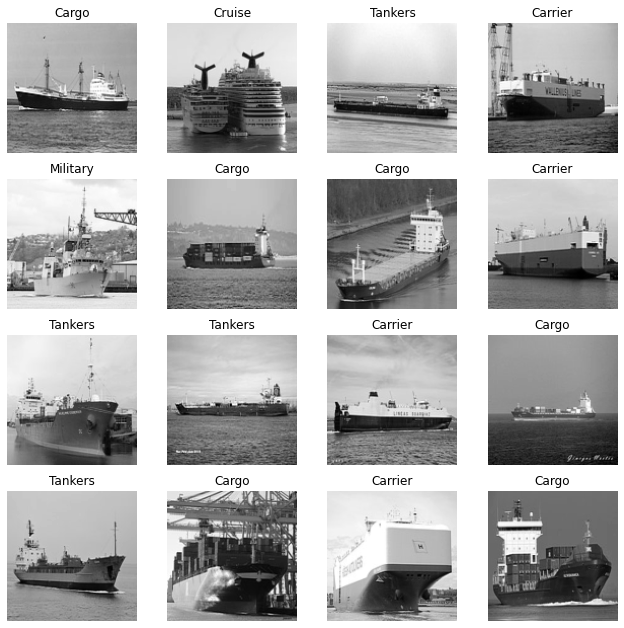

In [20]:
import matplotlib.pyplot as plt
import random

fig = plt.figure(figsize=(11,11))

for i in range(1,17):
  id = random.randint(0,len(train_set))
  images, label = train_set[id] 
  fig.add_subplot(4, 4, i)
  plt.imshow(images.squeeze(), cmap = 'gray')
  plt.axis('off');
  plt.title(classes[label]);


In [9]:
from torch.utils.data import DataLoader

DataLoadder kullanılarak resimler batchler halinde yüklenir


In [21]:
train_data = DataLoader(dataset = train_set, batch_size= 32, shuffle= True)
test_data = DataLoader(dataset = test_set, batch_size= 32)

In [12]:
class ModelEasy(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, out_shape: int):
    super().__init__()
    self.layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape, out_features= hidden_units),
        nn.Linear(in_features=hidden_units, out_features= out_shape)
    )
  def forward(self,x):
    return self.layer(x)

In [22]:
model1 = ModelEasy(input_shape=128*128, hidden_units= 5, out_shape= 5).to(device)

In [15]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model1.parameters(), lr=0.1)

In [16]:
epochs = 2

In [17]:
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (image, label) in enumerate(train_data):
        model1.train() 
        image = image.to(device)
        label = label.type(torch.long).to(device)
        # 1. Forward pass
        label_pred = model1(image)

        # 2. Calculate loss (per batch)
        loss = loss_fn(label_pred, label)
        train_loss += loss # accumulatively add up the loss per epoch 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

Epoch: 0
-------
Epoch: 1
-------
